In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import openpyxl
import xlrd
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from nilearn.connectome import ConnectivityMeasure
from pandas import DataFrame
import scipy as sc
from scipy import io
from scipy.stats import pearsonr
from os.path import join, exists, dirname, basename
from glob import glob
from brainspace import gradient
from random import randint
import nibabel as nib
import seaborn as sns

# Define path

In [2]:
main_path = '/store4/hschoi/1.Eat.DNN'
path_subj = glob('/store4/hschoi/HCP/*')
atlas_path = '/store1/hschoi/backup/hschoi/template'
save_path = '/store1/hschoi/backup/hschoi/1.Eat.DNN/data_HCP'

path_subj_lemon = sorted(glob('/store6/Public/Database/LEMON/MRI_Preprocessed_Derivetives/*'))
save_path_lemon = '/store1/hschoi/backup/hschoi/1.Eat.DNN/data_Lemon'

220117 additional analysis

ts demean 여부가 FC 값에 영향 없음 (하든 안하든 동일한 FC 값 나옴)

HCP, LEMON은 ts_dmean으로 FC구성, eNKI는 no demean으로 FC 구성

DC_BNA_Msctx2ctx_regout : sctx는 영역별 mean한 ts (210 ctx + 7 sctx) -> r to z FC 생성 (217,217), regression X -> sctx2ctx connection에서만 90% row-wise thresholding (217,210) -> row-wise sum, DC 생성 (subj당 217 vector) -> DC에서 age/sex regress out  

# Load HCP file, BNA atlas mapping

In [ ]:
import time
import nibabel as nib


Atlas = nib.load(join(atlas_path,'BNA_2mm.nii')).get_fdata()
n_roi = int(np.max(Atlas))
print(n_roi)
print(Atlas.shape)

save_ts = False

for p in path_subj:
    print(f'{path_subj.index(p)} / {len(path_subj)}')

    subj_id = basename(p)
    path_REST = glob(join(p,'MNINonLinear/Results/rfMRI_REST*'))
    
    for f in path_REST:
        start_time = time.time()
        save_path = f
        
        print(f' {subj_id} {basename(f)}')
        
        nii_file = glob(join(f,'*hp2000_clean.nii.gz'))
        fmri = nib.load(nii_file[0]).get_fdata()

        ts = np.array([np.mean(fmri[Atlas==roi], axis=0) for roi in range(1, n_roi+1)]) 
        if save_ts:
            print(ts.shape)
            np.save(join(save_path, f'ts_BNA.npy'), ts)
            print(' save ts')
        
        print(f' {time.time() - start_time} seconds!\n')

# Load HCP BNA time series, demean

In [65]:
import time
import nibabel as nib

for p in path_subj:
    print(f'{path_subj.index(p)} / {len(path_subj)}')

    subj_id = basename(p)
    path_REST = glob(join(p,'MNINonLinear/Results/rfMRI_REST*'))
    
    for f in path_REST:
        start_time = time.time()
        save_path = f
        
        print(f' {subj_id} {basename(f)}')
        
        ts_file = glob(join(f, 'ts_BNA.npy'))
        ts = np.load(ts_file[0])
        ts_demean = np.subtract(ts, ts.mean(axis=1).reshape(-1,1))
        np.save(join(save_path,'ts_demean_BNA.npy'),ts_demean)
        print(' save ts demean')
        print(f' {time.time() - start_time} seconds!\n')

0 / 1087
 100206 rfMRI_REST1_RL
 save ts demean
 0.10319828987121582 seconds!

 100206 rfMRI_REST1_LR
 save ts demean
 0.04677104949951172 seconds!

 100206 rfMRI_REST2_RL
 save ts demean
 0.030825376510620117 seconds!

 100206 rfMRI_REST2_LR
 save ts demean
 0.03420710563659668 seconds!

1 / 1087
 100307 rfMRI_REST1_RL
 save ts demean
 0.032347679138183594 seconds!

 100307 rfMRI_REST1_LR
 save ts demean
 0.07449936866760254 seconds!

 100307 rfMRI_REST2_LR
 save ts demean
 0.04777932167053223 seconds!

 100307 rfMRI_REST2_RL
 save ts demean
 0.035269737243652344 seconds!

2 / 1087
 100408 rfMRI_REST1_LR
 save ts demean
 0.03250622749328613 seconds!

 100408 rfMRI_REST1_RL
 save ts demean
 0.03367209434509277 seconds!

 100408 rfMRI_REST2_RL
 save ts demean
 0.03283238410949707 seconds!

 100408 rfMRI_REST2_LR
 save ts demean
 0.03382515907287598 seconds!

3 / 1087
 100610 rfMRI_REST1_RL
 save ts demean
 0.11860966682434082 seconds!

 100610 rfMRI_REST1_LR
 save ts demean
 0.127693176

# Concat HCP not twin times series, make FC

In [3]:
template_demo = pd.read_excel(join(main_path, 'S1200_total.xlsx'), sheet_name='NotTwin_QC', skiprows=0)

sub_list_hcp = template_demo['Subject']

In [5]:
sub_list_hcp

0      100206
1      101107
2      101309
3      101915
4      102008
        ...  
483    991267
484    992673
485    992774
486    993675
487    994273
Name: Subject, Length: 488, dtype: int64

In [4625]:
# check REST quality

for i in sub_list_hcp:
    REST_list = glob(join(path_subj, f'{i}/MNINonLinear/Results/*'))
    
    if len(REST_list) !=4:
        print(i, len(REST_list))
print('QC finish')

100206 5
101107 5
101309 5
101915 5
102008 5
102109 5
102513 5
102614 5
102715 5
103111 5
103212 5
103414 5
105216 5
105620 5
106319 5
107321 5
107725 5
108222 5
108525 5
108828 5
109325 5
109830 5
110411 5
110613 5
111716 5
112112 5
112314 5
113215 5
113619 5
114318 5
114419 5
114621 5
115219 5
115724 5
117122 5
117324 5
117930 5
118124 5
118528 5
118730 5
118932 5
119025 5
119126 5
119732 5
120515 5
120717 5
121416 5
121618 5
121921 5
122620 5
123117 5
123420 5
124220 5
124624 5
125222 5
126628 5
127327 5
127630 5
127933 5
129129 5
129634 5
130013 5
130821 5
131419 5
131924 5
132017 5
133827 5
133928 5
134223 5
134324 5
134425 5
135225 5
135629 5
135730 5
136126 5
136227 5
136631 5
136732 5
136833 5
137229 5
137633 5
137936 5
138130 5
138231 5
138332 5
138534 5
138837 5
140319 5
140824 5
140925 5
142828 5
144125 5
144428 5
144832 5
146331 5
146836 5
147030 5
147636 5
147737 5
148032 5
148335 5
148840 5
149236 5
149539 5
149842 5
150625 5
150726 5
151223 5
151324 5
151627 5
151829 5
1

In [162]:
import time

for i in sub_list_hcp:
    print(f'{np.where(sub_list == i)[0][0]} / {len(sub_list_hcp)}, {i}')
    
    start_time = time.time()
    
    folder_name = str(i)
    if not(os.path.isdir(join(save_path,f'{folder_name}'))):
        os.makedirs(os.path.join(save_path,f'{folder_name}'))
    
    REST_list = sorted(glob(join(path_subj, f'{i}/MNINonLinear/Results/*')))
    LR1 = np.load(f'{REST_list[0]}/ts_demean_BNA.npy')
    RL1 = np.load(f'{REST_list[1]}/ts_demean_BNA.npy')
    LR2 = np.load(f'{REST_list[2]}/ts_demean_BNA.npy')
    RL2 = np.load(f'{REST_list[3]}/ts_demean_BNA.npy')
    
    ts_demean_stacked = np.concatenate((LR1,RL1,LR2,RL2), axis=1)
    conn_mat =np.nan_to_num(np.where(np.eye(n_roi) ==1, 0, np.corrcoef(ts_demean_stacked)))
    conn_mat_rtoz =  np.nan_to_num(np.arctanh(conn_mat),nan=0.0)
    
    np.save(join(save_path,folder_name,'ts_demean_stacked_BNA.npy'), ts_demean_stacked)
    np.save(join(save_path,folder_name,'conn_mat_pear_BNA.npy'), conn_mat)
    np.save(join(save_path,folder_name,'conn_mat_pear_rtoz_BNA.npy'), conn_mat_rtoz)
    
    print(' ts stacked')
    print(' conn mat')
    print(' conn mat r to z')
    
    print(f'{time.time() - start_time} seconds!\n')

0 / 488, 100206
 ts stacked
 conn mat
 conn mat r to z
0.14833569526672363 seconds!

1 / 488, 101107
 ts stacked
 conn mat
 conn mat r to z
0.15418577194213867 seconds!

2 / 488, 101309
 ts stacked
 conn mat
 conn mat r to z
0.14560246467590332 seconds!

3 / 488, 101915
 ts stacked
 conn mat
 conn mat r to z
0.20124077796936035 seconds!

4 / 488, 102008
 ts stacked
 conn mat
 conn mat r to z
0.15064191818237305 seconds!

5 / 488, 102109
 ts stacked
 conn mat
 conn mat r to z
0.1532294750213623 seconds!

6 / 488, 102513
 ts stacked
 conn mat
 conn mat r to z
0.14612650871276855 seconds!

7 / 488, 102614
 ts stacked
 conn mat
 conn mat r to z
0.14660048484802246 seconds!

8 / 488, 102715
 ts stacked
 conn mat
 conn mat r to z
0.1476297378540039 seconds!

9 / 488, 103111
 ts stacked
 conn mat
 conn mat r to z
0.15967607498168945 seconds!

10 / 488, 103212
 ts stacked
 conn mat
 conn mat r to z
0.1407783031463623 seconds!

11 / 488, 103414
 ts stacked
 conn mat
 conn mat r to z
0.155360698

# Make gradient (eigenvector) template (using HCP)

In [72]:
# Load only surface cortex
file_list_hcp = [np.load(join(save_path, str(i), 'conn_mat_pear_BNA.npy'))[:210,:210] for i in sub_list_hcp]
    
grp_conn_mat = np.array(file_list_hcp).mean(axis=0)
grp_conn_mat_rtoz = np.nan_to_num(np.arctanh(grp_conn_mat))

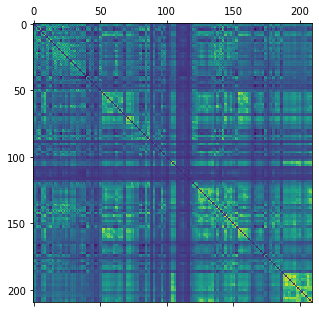

In [113]:
# FC Figure
plt.figure(figsize = (5,5)) # (20,20)
plt.matshow(grp_conn_mat,  fignum=1)

In [4628]:
for sparsity in [0.5, 0.8, 0.75, 0.7, 0.6]:

#     sparsity = 0.9

    k = str(int(100-sparsity*100))
    k = k.zfill(2)

    print(f'Top {k}')

    noaff_grp_conn_mat = gradient.compute_affinity(grp_conn_mat_rtoz, sparsity = sparsity)
    aff_grp_conn_mat = gradient.compute_affinity(grp_conn_mat_rtoz, kernel = 'cosine', sparsity = sparsity)

    print(f'noaff isnan : {np.isnan(noaff_grp_conn_mat).sum()}, symmetric : {gradient.is_symmetric(noaff_grp_conn_mat)}')
    print(f'aff isnan : {np.isnan(aff_grp_conn_mat).sum()}, symmetric : {gradient.is_symmetric(aff_grp_conn_mat)}')

    # rmsubcor = remove subcortical cortex

    np.save(join(save_path, f'noaff_grp_conn_mat_pear_top{k}_BNA_rmsubcor.npy'), noaff_grp_conn_mat)
    np.save(join(save_path, f'aff_grp_conn_mat_pear_top{k}_BNA_rmsubcor.npy'), aff_grp_conn_mat)

Top 50
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
Top 20
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
Top 25
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
Top 30
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
Top 40
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True


In [1219]:
comp_num = 10

# grp_aff = np.load(join(save_path, f'noaff_grp_conn_mat_pear_top10_BNA_rmsubcor.npy'))
grp_aff = np.load(join(save_path, f'aff_grp_conn_mat_pear_top10_BNA_rmsubcor.npy'))

# emb = gradient.embedding.PCAMaps(n_components = comp_num)
emb = gradient.embedding.DiffusionMaps(n_components = comp_num)

emb.fit(grp_aff)
ref_lam = emb.lambdas_ 
ref_PC = emb.maps_

grad1 = ref_PC[:,0]
grad2 = ref_PC[:,1]
grad3 = ref_PC[:,2]

# Load Validation datset (Lemon) time series, demean

In [172]:
import time

Atlas = nib.load(join(atlas_path,'BNA_2mm.nii')).get_fdata()
n_roi = int(np.max(Atlas))
print(n_roi)
print(Atlas.shape)

save_ts = True

for p in path_subj[156:]:
    print(f'{path_subj.index(p)} / {len(path_subj)}')
    
    start_time = time.time()

    subj_id = basename(p)
    folder_name = subj_id
    print(subj_id)
    
    nii_file = glob(join(p, 'func','*MNI2mm*'))
    
    if not nii_file:
        print('Pass')
        continue
    
    if not (os.path.isdir(os.path.join(save_path_lemon,f'{folder_name}'))):
            os.makedirs(os.path.join(save_path_lemon,f'{folder_name}'))
    
    
    fmri = nib.load(nii_file[0]).get_fdata()
    
    ts = np.array([np.mean(fmri[Atlas==roi], axis=0) for roi in range(1, n_roi+1)]) 
    ts_demean = np.subtract(ts, ts.mean(axis=1).reshape(-1,1))
    
    conn_mat =np.nan_to_num(np.where(np.eye(n_roi) ==1, 0, np.corrcoef(ts_demean)))
    conn_mat_rtoz =  np.nan_to_num(np.arctanh(conn_mat),nan=0.0)
        
    if save_ts:
        print(ts.shape)
        np.save(join(save_path_lemon,folder_name, f'ts_BNA.npy'), ts)
        print(' save ts')
        np.save(join(save_path_lemon,folder_name,'ts_demean_BNA.npy'),ts_demean)
        print(' save ts demean')
        np.save(join(save_path_lemon,folder_name,'conn_mat_pear_BNA.npy'), conn_mat)
        print(' conn mat')
        np.save(join(save_path_lemon,folder_name,'conn_mat_pear_rtoz_BNA.npy'), conn_mat_rtoz)
        print(' conn mat r to z')
        
    print(f' {time.time() - start_time} seconds!\n')


246
(91, 109, 91)
156 / 227
sub-010250
(246, 652)
 save ts
 save ts demean
 conn mat
 conn mat r to z
 43.58163261413574 seconds!

157 / 227
sub-010251
Pass
158 / 227
sub-010252
(246, 652)
 save ts
 save ts demean
 conn mat
 conn mat r to z
 37.318877935409546 seconds!

159 / 227
sub-010253
(246, 652)
 save ts
 save ts demean
 conn mat
 conn mat r to z
 38.73622488975525 seconds!

160 / 227
sub-010254
(246, 652)
 save ts
 save ts demean
 conn mat
 conn mat r to z
 39.712749004364014 seconds!

161 / 227
sub-010255
(246, 652)
 save ts
 save ts demean
 conn mat
 conn mat r to z
 42.138803005218506 seconds!

162 / 227
sub-010256
(246, 652)
 save ts
 save ts demean
 conn mat
 conn mat r to z
 42.73481512069702 seconds!

163 / 227
sub-010257
(246, 652)
 save ts
 save ts demean
 conn mat
 conn mat r to z
 35.87265396118164 seconds!

164 / 227
sub-010258
Pass
165 / 227
sub-010260
(246, 652)
 save ts
 save ts demean
 conn mat
 conn mat r to z
 43.094831228256226 seconds!

166 / 227
sub-010261
(

# Make gradient Lemon

In [5]:
demo_lemon = pd.read_excel(join(main_path, 'LEMON_Demographic.xlsx'), sheet_name='n=212', skiprows=1, usecols='A:Z')
sub_list_lemon = demo_lemon['ID']

file_list = np.array([glob(join(main_path,'data_Lemon',i)) for i in sub_list_lemon]).flatten()

len(file_list)

212

In [227]:
for sparsity in [0.9]:

#     sparsity = 0.75 # 0.75 0.5 0.8 0.7 0.6

    k = str(int(100-sparsity*100))
    k = k.zfill(2)

    print(f'Top {k}')

    folder_name = f'top{k}'

    for i in file_list:
        print(f'{np.where(file_list==i)[0].item()} / {len(file_list)}')

        if not (os.path.isdir(os.path.join(i,folder_name))):
            os.makedirs(os.path.join(i,folder_name))
        else:
            pass

        conn_mat = np.load(join(i,'conn_mat_pear_rtoz_BNA.npy'))[:210, :210]

        noaff_conn_mat = gradient.compute_affinity(conn_mat, sparsity = sparsity)
        aff_conn_mat = gradient.compute_affinity(conn_mat, kernel = 'cosine', sparsity = sparsity)

        print(f'noaff isnan : {np.isnan(noaff_conn_mat).sum()}, symmetric : {gradient.is_symmetric(noaff_conn_mat)}')
        print(f'aff isnan : {np.isnan(aff_conn_mat).sum()}, symmetric : {gradient.is_symmetric(aff_conn_mat)}')

        np.save(join(i, folder_name, f'noaff_conn_mat_pear_top{k}_BNA_rmsubcor.npy'), noaff_conn_mat)
        np.save(join(i, folder_name, f'aff_conn_mat_pear_top{k}_BNA_rmsubcor.npy'), aff_conn_mat)

Top 10
0 / 212
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
1 / 212
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
2 / 212
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
3 / 212
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
4 / 212
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
5 / 212
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
6 / 212
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
7 / 212
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
8 / 212
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
9 / 212
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
10 / 212
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
11 / 212
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
12 / 212
noaff isnan : 0, symmetric : False
aff isnan : 0, symmetric : True
13 / 212
noaff 

In [228]:
for i in [10]:

    Topk = str(i) # 25 50 20 30 40
    folder = f'top{Topk}'

    grp_noaff = np.load(join(save_path, f'noaff_grp_conn_mat_pear_top{Topk}_BNA_rmsubcor.npy'))
    grp_aff = np.load(join(save_path, f'aff_grp_conn_mat_pear_top{Topk}_BNA_rmsubcor.npy'))

    comp_num = 10

    # PCA
    print('PCA')
    emb_pca = gradient.embedding.PCAMaps(n_components = comp_num)
    emb_pca.fit(grp_noaff)
    ref_lam_pca = emb_pca.lambdas_ 
    ref_PC_pca = emb_pca.maps_ 

    for i in file_list:
        print(f'{np.where(file_list==i)[0].item()}', '', end='', flush=True)
        dat = np.load(join(i,folder,f'noaff_conn_mat_pear_top{Topk}_BNA_rmsubcor.npy'))

        emb_pca.fit(dat)
        lam, grad = [None]*1, [None]*1
        lam[0], grad[0] = emb_pca.lambdas_ , emb_pca.maps_

        pa = gradient.ProcrustesAlignment(n_iter=10)
        pa.fit(grad, reference=ref_PC_pca)
        aligned = np.array(pa.aligned_)

        np.save(join(i,folder,f'gradients_PCA_top{Topk}_BNA_rmsubcor.npy'), aligned)

    print('\n')

    # Diffusion map
    print('Diffusion Map')
    emb_dm = gradient.embedding.DiffusionMaps(n_components = comp_num)
    emb_dm.fit(grp_aff)
    ref_lam_dm = emb_dm.lambdas_ 
    ref_PC_dm = emb_dm.maps_ 

    for i in file_list:
        print(f'{np.where(file_list==i)[0].item()}', '', end='', flush=True)
        dat = np.load(join(i,folder,f'aff_conn_mat_pear_top{Topk}_BNA_rmsubcor.npy'))

        emb_dm.fit(dat)
        lam, grad = [None]*1, [None]*1
        lam[0], grad[0] = emb_dm.lambdas_ , emb_dm.maps_

        pa = gradient.ProcrustesAlignment(n_iter=10)
        pa.fit(grad, reference=ref_PC_dm)
        aligned = np.array(pa.aligned_)

        np.save(join(i,folder,f'gradients_DM_top{Topk}_BNA_rmsubcor.npy'), aligned)

PCA
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 

Diffusion Map
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 

# Make sctx mean included FC eNkI

In [375]:
demo = pd.read_excel(join(main_path, 'Enhanced_NKI_sorted.xlsx'), sheet_name='n=424', skiprows=1)
sub_list = demo['ID']
age = demo['Age']
sex = demo['Sex (M1F2)']

file_list = []


file_list = [join(main_path,'data',i) for i in sub_list]

len(file_list)

424

In [357]:
# make mean sctx FC file

for i in file_list:
    print(f'{file_list.index(i)+1} / {len(file_list)}')
    
    ts = np.load(join(i,'ts_BNA.npy'))
    ts_ctx = ts[:210]
    
    # sctx list
    ts_amyg = ts[210:214].mean(axis=0)
    ts_hippo = ts[214:218].mean(axis=0)
    ts_cau = ts[[218,219,226,227]].mean(axis=0)
    ts_palli = ts[220:222].mean(axis=0)
    ts_accum = ts[222:224].mean(axis=0)
    ts_puta = ts[[224,225,228,229]].mean(axis=0)
    ts_thal = ts[230:].mean(axis=0)
    
    ts_mean_sctx = np.vstack((ts_amyg, ts_hippo, ts_cau, ts_palli, ts_accum, ts_puta, ts_thal))
    
    ts_whole_Msctx = np.concatenate((ts_ctx, ts_mean_sctx), axis=0)
    
    np.save(join(i, 'ts_whole_Msctx_BNA.npy'), ts_whole_Msctx)
    print('save ts')
    
    n_roi=217 # ctx 210 + sctx 7
    conn_mat =np.nan_to_num(np.where(np.eye(n_roi) ==1, 0, np.corrcoef(ts_whole_Msctx)))
    conn_mat_rtoz =  np.nan_to_num(np.arctanh(conn_mat),nan=0.0)
    
    np.save(join(i,'conn_mat_pear_whole_Msctx_BNA.npy'), conn_mat)
    print('save conn mat')
    np.save(join(i,'conn_mat_pear_rtoz_whole_Msctx_BNA.npy'), conn_mat_rtoz)
    print('save conn mat r to z')
    print('')

0 / 424
save ts
save conn mat
save conn mat r to z

1 / 424
save ts
save conn mat
save conn mat r to z

2 / 424
save ts
save conn mat
save conn mat r to z

3 / 424
save ts
save conn mat
save conn mat r to z

4 / 424
save ts
save conn mat
save conn mat r to z

5 / 424
save ts
save conn mat
save conn mat r to z

6 / 424
save ts
save conn mat
save conn mat r to z

7 / 424
save ts
save conn mat
save conn mat r to z

8 / 424
save ts
save conn mat
save conn mat r to z

9 / 424
save ts
save conn mat
save conn mat r to z

10 / 424
save ts
save conn mat
save conn mat r to z

11 / 424
save ts
save conn mat
save conn mat r to z

12 / 424
save ts
save conn mat
save conn mat r to z

13 / 424
save ts
save conn mat
save conn mat r to z

14 / 424
save ts
save conn mat
save conn mat r to z

15 / 424
save ts
save conn mat
save conn mat r to z

16 / 424
save ts
save conn mat
save conn mat r to z

17 / 424
save ts
save conn mat
save conn mat r to z

18 / 424
save ts
save conn mat
save conn mat r to z

19 

In [373]:
# make sctx to ctx connection DC

sparsity=0.9
k = str(int(100-sparsity*100))
k = k.zfill(2)
print(f'Top {k}')
folder_name = f'top{k}'

for i in file_list:
    print(f'{file_list.index(i)+1} / {len(file_list)}')
    conn_mat_rtoz = np.load(join(i, 'conn_mat_pear_rtoz_whole_Msctx_BNA.npy'))[:,:210]
#     print(conn_mat_rtoz.shape)
    
    noaff_conn_mat = gradient.compute_affinity(np.nan_to_num(conn_mat_rtoz, nan=0.0), sparsity=sparsity)
    DC = noaff_conn_mat.sum(axis=1) # row-wise sum
    np.save(join(i, folder_name, f'noaff_conn_mat_pear_top{k}_Msctx2ctx_BNA.npy'),noaff_conn_mat)
    np.save(join(i, folder_name, f'DC_BNA_Msctx2ctx.npy'), DC)

Top 10
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(217, 210)
(21

In [380]:
DC_file = np.array([np.load(join(i, 'top10', f'DC_BNA_Msctx2ctx.npy')) for i in file_list])
print(DC_file.shape)

(424, 217)


In [381]:
# DC age, sex regressed out

import statsmodels as sm
from statsmodels.api import GLM

list_reg_out = []

for i in range(DC_file.shape[1]):
    print(i, ' ', end='', flush=True)
    a = GLM(DC_file[:,i],sm.api.add_constant(np.array([sex,age,sex*age]).T))
    
    res_a = a.fit()
    # res.summary()

    list_reg_out.append(res_a.resid_response)
     
DC_regout = np.array(list_reg_out).T

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208  209  210  211  212  213  214  215  216  

In [384]:
for i,x in enumerate(file_list):
    print(f'{i+1} / {len(file_list)}')
    np.save(join(x, 'top10', f'DC_BNA_Msctx2ctx_regout.npy'), DC_regout[i])

1 / 424
2 / 424
3 / 424
4 / 424
5 / 424
6 / 424
7 / 424
8 / 424
9 / 424
10 / 424
11 / 424
12 / 424
13 / 424
14 / 424
15 / 424
16 / 424
17 / 424
18 / 424
19 / 424
20 / 424
21 / 424
22 / 424
23 / 424
24 / 424
25 / 424
26 / 424
27 / 424
28 / 424
29 / 424
30 / 424
31 / 424
32 / 424
33 / 424
34 / 424
35 / 424
36 / 424
37 / 424
38 / 424
39 / 424
40 / 424
41 / 424
42 / 424
43 / 424
44 / 424
45 / 424
46 / 424
47 / 424
48 / 424
49 / 424
50 / 424
51 / 424
52 / 424
53 / 424
54 / 424
55 / 424
56 / 424
57 / 424
58 / 424
59 / 424
60 / 424
61 / 424
62 / 424
63 / 424
64 / 424
65 / 424
66 / 424
67 / 424
68 / 424
69 / 424
70 / 424
71 / 424
72 / 424
73 / 424
74 / 424
75 / 424
76 / 424
77 / 424
78 / 424
79 / 424
80 / 424
81 / 424
82 / 424
83 / 424
84 / 424
85 / 424
86 / 424
87 / 424
88 / 424
89 / 424
90 / 424
91 / 424
92 / 424
93 / 424
94 / 424
95 / 424
96 / 424
97 / 424
98 / 424
99 / 424
100 / 424
101 / 424
102 / 424
103 / 424
104 / 424
105 / 424
106 / 424
107 / 424
108 / 424
109 / 424
110 / 424
111 / 42

# Make gradient eNKI

In [4]:
demo = pd.read_excel(join(main_path, 'Enhanced_NKI_sorted.xlsx'), sheet_name='n=424', skiprows=1)
sub_list = demo['ID']

file_list = []


file_list = [join(main_path,'data',i) for i in sub_list]

len(file_list)

424

In [ ]:
# FC thrsholding

for sparsity in [0.5, 0.8, 0.7, 0.6]:

#     sparsity = 0.75 # 0.75 0.5 0.8 0.7 0.6

    k = str(int(100-sparsity*100))
    k = k.zfill(2)

    print(f'Top {k}')

    folder_name = f'top{k}'

    for i in file_list:
        print(f'{file_list.index(i)} / {len(file_list)}')

        if not (os.path.isdir(os.path.join(i,f'{folder_name}'))):
            os.makedirs(os.path.join(i,f'{folder_name}'))

        conn_mat = np.load(join(i,'conn_mat_pear_rtoz_BNA.npy'))[:210, :210]

        noaff_conn_mat = gradient.compute_affinity(conn_mat, sparsity = sparsity)
        aff_conn_mat = gradient.compute_affinity(conn_mat, kernel = 'cosine', sparsity = sparsity)

        print(f'noaff isnan : {np.isnan(noaff_conn_mat).sum()}, symmetric : {gradient.is_symmetric(noaff_conn_mat)}')
        print(f'aff isnan : {np.isnan(aff_conn_mat).sum()}, symmetric : {gradient.is_symmetric(aff_conn_mat)}')

        np.save(join(i, folder_name, f'noaff_conn_mat_pear_top{k}_BNA_rmsubcor.npy'), noaff_conn_mat)
        np.save(join(i, folder_name, f'aff_conn_mat_pear_top{k}_BNA_rmsubcor.npy'), aff_conn_mat)

In [42]:
# Make eigenvector

for i in [50, 20, 30, 40]:

    Topk = str(i) # 25 50 20 30 40
    folder = f'top{Topk}'

    grp_noaff = np.load(join(save_path, f'noaff_grp_conn_mat_pear_top{Topk}_BNA_rmsubcor.npy'))
    grp_aff = np.load(join(save_path, f'aff_grp_conn_mat_pear_top{Topk}_BNA_rmsubcor.npy'))

    comp_num = 10

    # PCA
    print('PCA')
    emb_pca = gradient.embedding.PCAMaps(n_components = comp_num)
    emb_pca.fit(grp_noaff)
    ref_lam_pca = emb_pca.lambdas_ 
    ref_PC_pca = emb_pca.maps_ 

    for i in file_list:
        print(f'{file_list.index(i)}', '', end='', flush=True)
        dat = np.load(join(i,folder,f'noaff_conn_mat_pear_top{Topk}_BNA_rmsubcor.npy'))

        emb_pca.fit(dat)
        lam, grad = [None]*1, [None]*1
        lam[0], grad[0] = emb_pca.lambdas_ , emb_pca.maps_

        pa = gradient.ProcrustesAlignment(n_iter=10)
        pa.fit(grad, reference=ref_PC_pca)
        aligned = np.array(pa.aligned_)

        np.save(join(i,folder,f'gradients_PCA_top{Topk}_BNA_rmsubcor.npy'), aligned)

    print('\n')

    # Diffusion map
    print('Diffusion Map')
    emb_dm = gradient.embedding.DiffusionMaps(n_components = comp_num)
    emb_dm.fit(grp_aff)
    ref_lam_dm = emb_dm.lambdas_ 
    ref_PC_dm = emb_dm.maps_ 

    for i in file_list:
        print(f'{file_list.index(i)}', '', end='', flush=True)
        dat = np.load(join(i,folder,f'aff_conn_mat_pear_top{Topk}_BNA_rmsubcor.npy'))

        emb_dm.fit(dat)
        lam, grad = [None]*1, [None]*1
        lam[0], grad[0] = emb_dm.lambdas_ , emb_dm.maps_

        pa = gradient.ProcrustesAlignment(n_iter=10)
        pa.fit(grad, reference=ref_PC_dm)
        aligned = np.array(pa.aligned_)

        np.save(join(i,folder,f'gradients_DM_top{Topk}_BNA_rmsubcor.npy'), aligned)


PCA
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 27

[0.19974802 0.19526591 0.14284168 0.09317503 0.08755593 0.0823581
 0.06166579 0.05430127 0.0426843  0.04040397]


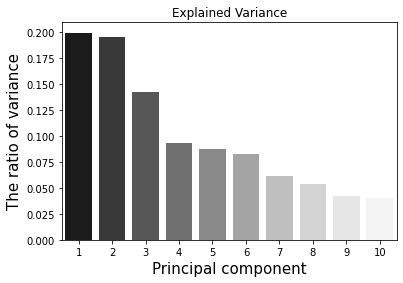

In [35]:
grp_aff = np.load(join(path_subj, f'aff_grp_conn_mat_pear_top10_BNA_rmsubcor.npy'))

comp_num = 10

emb_dm = gradient.embedding.DiffusionMaps(n_components = comp_num)
emb_dm.fit(grp_aff)
ref_lam_dm = emb_dm.lambdas_ 
ref_PC_dm = emb_dm.maps_ 

sns.barplot(x = list(range(1,11) ), y = ref_lam_dm/ref_lam_dm.sum(), palette='Greys_r') # 'ch:2,r=1,l=.6' Greys_r
plt.xlabel('Principal component', fontsize = 15)
plt.ylabel('The ratio of variance', fontsize = 15)
plt.title('Explained Variance')
plt.grid(False)

print(ref_lam_dm/ref_lam_dm.sum())

# Clustering

In [23]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, OneHotEncoder

age = demo['Age']
sex = demo['Sex (M1F2)']
BMI = demo['BMI']
WHR = demo['WHR']
EDE_Q_R = demo['Restraint']
EDE_Q_E_con = demo['Eating concern']
EDE_Q_S_con = demo['Shape concern']
EDE_Q_W_con = demo['Weight concern']
TFEQ_F1 = demo['Factor 1']
TFEQ_F2 = demo['Factor 2']
TFEQ_F3 = demo['Factor 3']

EDE_Q_global = (EDE_Q_R+EDE_Q_E_con+EDE_Q_S_con+EDE_Q_W_con) / 4
EDE_Q_con = (EDE_Q_E_con+EDE_Q_S_con+EDE_Q_W_con) / 3

scaler = MinMaxScaler() # MinMaxScaler StandardScaler MaxAbsScaler RobustScaler
 
y_target = np.array(BMI)
y_scaled = scaler.fit_transform(np.array(y_target).reshape(-1,1)).reshape(-1)

demographic_label = ['age', 'BMI', 'WHR', 'EDE_Q_R', 'EDE_Q_E_con', 'EDE_Q_S_con', 'EDE_Q_W_con', 'TFEQ_F1', 'TFEQ_F2', 'TFEQ_F3']

for i, x in enumerate([age, BMI, WHR, EDE_Q_R, EDE_Q_E_con, EDE_Q_S_con, EDE_Q_W_con, TFEQ_F1, TFEQ_F2, TFEQ_F3]):
    print(demographic_label[i], ':', np.array(x).shape, np.round(x.mean(),2), np.round(x.std(),2), '      Min Max', np.round(x.min(),2), np.round(x.max(),2))
    
print('Sex F M : ',len(np.where(sex==2)[0]), len(np.where(sex==1)[0]))

age : (424,) 47.07 18.89       Min Max 18.15 85.62
BMI : (424,) 27.82 5.77       Min Max 16.26 47.93
WHR : (424,) 0.84 0.09       Min Max 0.59 1.3
EDE_Q_R : (424,) 1.29 1.41       Min Max 0.0 6.0
EDE_Q_E_con : (424,) 0.35 0.72       Min Max 0.0 4.6
EDE_Q_S_con : (424,) 1.64 1.41       Min Max 0.0 6.0
EDE_Q_W_con : (424,) 1.32 1.23       Min Max 0.0 5.6
TFEQ_F1 : (424,) 8.67 4.94       Min Max 0 20
TFEQ_F2 : (424,) 5.03 3.45       Min Max 0 15
TFEQ_F3 : (424,) 4.26 3.36       Min Max 0 15
Sex F M :  282 142


In [17]:
print(len(np.where((BMI>=18.5)&(BMI<25))[0]))
print(len(np.where((BMI>=25)&(BMI<30))[0]))
print(len(np.where(BMI>=30)[0]))

144
151
121


In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, OneHotEncoder
# Lemon

age_lemon = demo_lemon['Age']
sex_lemon = demo_lemon['Gender_ 1=male_2=female']
BMI_lemon = demo_lemon['BMI (kg/m2)']
TFEQ_F1_lemon = demo_lemon['FEV_KK']
TFEQ_F2_lemon = demo_lemon['FEV_STOER']
TFEQ_F3_lemon = demo_lemon['FEV_HUNGER']

scaler = MinMaxScaler() # MinMaxScaler StandardScaler MaxAbsScaler RobustScaler
 
y_target = np.array(BMI_lemon)
y_scaled = scaler.fit_transform(np.array(y_target).reshape(-1,1)).reshape(-1)
    
demographic_label = ['age', 'BMI', 'TFEQ_F1', 'TFEQ_F2', 'TFEQ_F3']

for i, x in enumerate([age_lemon, BMI_lemon, TFEQ_F1_lemon, TFEQ_F2_lemon, TFEQ_F3_lemon]):
    print(demographic_label[i], ':', np.array(x).shape, np.round(x.mean(),2), np.round(x.std(),2), '      Min Max', np.round(x.min(),2), np.round(x.max(),2))
    
print('Sex F M : ',len(np.where(sex_lemon==2)[0]), len(np.where(sex_lemon==1)[0]))

age : (212,) 38.97 19.8       Min Max 23 78
BMI : (212,) 24.17 3.67       Min Max 17.93 36.65
TFEQ_F1 : (212,) 6.36 4.65       Min Max 0 18
TFEQ_F2 : (212,) 4.82 2.61       Min Max 0 15
TFEQ_F3 : (212,) 4.61 2.94       Min Max 0 12
Sex F M :  75 137


In [19]:
print(len(np.where((BMI_lemon>=18.5)&(BMI_lemon<25))[0]))
print(len(np.where((BMI_lemon>=25)&(BMI_lemon<30))[0]))
print(len(np.where(BMI_lemon>=30)[0]))

134
58
16


# Demographinc statistic

In [40]:
Dis_demo = [age, BMI, TFEQ_F1, TFEQ_F2, TFEQ_F3]
Rep_demo = [age_lemon, BMI_lemon, TFEQ_F1_lemon, TFEQ_F2_lemon, TFEQ_F3_lemon]
demographic_label = ['age', 'BMI', 'TFEQ_F1', 'TFEQ_F2', 'TFEQ_F3']

for i in range(len(Dis_demo)):

    [s_0,p_0] = sc.stats.ttest_ind(Dis_demo[i], Rep_demo[i], equal_var = False, axis=0)
    print(f'{demographic_label[i]} : {p_0}')

age : 1.1660608147249171e-06
BMI : 1.24743303181023e-20
TFEQ_F1 : 1.331223028993814e-08
TFEQ_F2 : 0.3927388155477983
TFEQ_F3 : 0.17329722358817132


In [298]:
# discovery, replication dataset sex chi-square

chi_ob = [282, 142] # discovery(eNKI) F:M
chi_expect = [75,137] # replication(Lemon) F:M

chi_stat, chi_pval = sc.stats.chisquare(chi_ob, f_exp=chi_expect, axis=None, ddof = [0,1,2])

print(chi_stat)
print(chi_pval)

571.5024817518249
[2.64537516e-126             nan             nan]


In [45]:
path_data = join(main_path,'data')
path_data_Lemon = join(main_path,'data_Lemon')

topk = 'top10' # top10 top20 top25 top30 top40 top50

file_list = np.concatenate([np.load(join(path_data,i, topk, f'gradients_DM_{topk}_BNA_rmsubcor.npy')) for i in sub_list], axis=0) # gradients_PCA_top10_BNA gradients_DM_top10_BNA
# file_list = np.concatenate([np.load(join(path_data_Lemon,i, topk, f'gradients_DM_{topk}_BNA_rmsubcor.npy')) for i in sub_list_lemon], axis=0) # gradients_PCA_top10_BNA gradients_DM_top10_BNA


grad1_list = file_list[:,:,0]
grad2_list = file_list[:,:,1]
grad3_list = file_list[:,:,2]

# gradient z normalized

grad1_list_znorm = sc.stats.zscore(grad1_list, axis=1)
grad2_list_znorm = sc.stats.zscore(grad2_list, axis=1)
grad3_list_znorm = sc.stats.zscore(grad3_list, axis=1)

# gradient concatenate
grad_list_znorm_stacked = np.concatenate((grad1_list_znorm, grad2_list_znorm, grad3_list_znorm), axis=1)

In [46]:
# gradient age, sex regressed out

import statsmodels as sm
from statsmodels.api import GLM

list_reg_out_a = []
list_reg_out_b = []
list_reg_out_c = []
list_reg_out_d = []

for i in range(grad_list_znorm_stacked.shape[1]):
    print(i, ' ', end='', flush=True)
    a = GLM(grad_list_znorm_stacked[:,i],sm.api.add_constant(np.array([sex,age,sex*age]).T))
    
    res_a = a.fit()
    # res.summary()

    list_reg_out_a.append(res_a.resid_response)
     
grad_list_znorm_stacked_regout = np.array(list_reg_out_a).T


for i in range(grad1_list_znorm.shape[1]):
    print(i, ' ', end='', flush=True)
    b = GLM(grad1_list_znorm[:,i],sm.api.add_constant(np.array([sex,age,sex*age]).T))
    c = GLM(grad2_list_znorm[:,i],sm.api.add_constant(np.array([sex,age,sex*age]).T))
    d = GLM(grad3_list_znorm[:,i],sm.api.add_constant(np.array([sex,age,sex*age]).T))

    res_b = b.fit()
    res_c = c.fit()
    res_d = d.fit()
    # res.summary()

    list_reg_out_b.append(res_b.resid_response)
    list_reg_out_c.append(res_c.resid_response)
    list_reg_out_d.append(res_d.resid_response)
    
    
grad1_list_znorm_regout = np.array(list_reg_out_b).T
grad2_list_znorm_regout = np.array(list_reg_out_c).T
grad3_list_znorm_regout = np.array(list_reg_out_d).T

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208  209  210  211  212  213  214  215  216  217  218  219  220  221  

In [47]:
grad1_DM_temp = np.load(join(main_path, 'data_HCP', 'grad1_DM_top10_temp_BNA_rmsubcor.npy'))[:210]
grad2_DM_temp = np.load(join(main_path, 'data_HCP', 'grad2_DM_top10_temp_BNA_rmsubcor.npy'))[:210]
grad3_DM_temp = np.load(join(main_path, 'data_HCP', 'grad3_DM_top10_temp_BNA_rmsubcor.npy'))[:210]
grad_DM_temp = np.array([grad1_DM_temp, grad2_DM_temp, grad3_DM_temp]).T

grad_list_znorm_stacked_regout_3d = np.dstack((grad1_list_znorm_regout, grad2_list_znorm_regout, grad3_list_znorm_regout))

# Manifold Eccentricity
ncompo = 3

nroi = grad_DM_temp.shape[0]
gm_center = grad_DM_temp[:,:ncompo].mean()
ME = np.array([np.sqrt(np.sum(np.square(gm_center-file_list[i,:,:ncompo]), axis=1)) for i in range(len(file_list))])
ME_regout = np.array([np.sqrt(np.sum(np.square(gm_center-grad_list_znorm_stacked_regout_3d[i,:,:ncompo]), axis=1)) for i in range(len(grad_list_znorm_stacked_regout_3d))])